# Time Series - Motifs and Discords
Data Understanding and Preparation
- Explore and prepare the time series dataset.
- Preprocess the dataset in order to be able to run time series
clustering; motif/anomaly discovery and classification. If the dataset is
too big for these tasks, you can use approximations (e.g. SAX, PAA etc)

Motifs/Discords
- Analyze the dataset for finding motifs and/or anomalies. Visualize and
discuss them and their relationship with shapelets.

Clustering
- Use at least two clustering algorithm on time series using an
appropriate distance.
- Analyze the clusters and highlight similarities and differences and
visualize the clusters using at least 2 dimensionality reduction
techniques.

Classification
Define one (or more) classification task and solve it using:
- KNN with at least two distances
    - Euclidean/Manhattan
    - DTW
    - Shapelets
    - Analyze the shapelets retrieved
- At least one other method (rocket, muse, cnn, rnn etc)

In [182]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
                            
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle
import random

from IPython.display import Audio 
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("seaborn-white")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

C:\Users\User\AppData\Local\Temp\ipykernel_26636\272436162.py:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


### TS libraries

In [183]:
#Time Series Preprocessing
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#Distances
from scipy.spatial.distance import euclidean, cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#Time Series Approximation
from scipy.signal import decimate
from pyts.approximation import DiscreteFourierTransform, SymbolicAggregateApproximation
from sklearn.decomposition import TruncatedSVD, randomized_svd
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

#Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import cm

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

#evaluation
from sklearn.metrics import silhouette_score,rand_score, adjusted_rand_score, mutual_info_score,\
                                adjusted_mutual_info_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from dtaidistance import dtw as dtw2

#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

#Matrixprofile
from matrixprofile import *
import stumpy
import kds #for the lift

In [184]:
def imp_data_npy(data_filename, data_npy, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    
    df_all = pd.concat([pd.read_csv(data_filename)['emotion'], pd.DataFrame(np.load(data_npy))], axis = 1)
    #df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = frac, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    scl_mv = TimeSeriesScalerMinMax()
    X = scl_mv.fit_transform(X)
    X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [185]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [186]:
def dtw_and_matrix(X_clust):
    X_clust = np.squeeze(X_clust)
    distance_matrix = []
    m = len(X_clust)    
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            distance_matrix.append(dtw.distance_fast(X_clust[i].astype('double'), X_clust[j].astype('double')))
    
    distance_matrix = np.array(distance_matrix)
    d_mat = squareform(distance_matrix)

    return distance_matrix, d_mat
    

In [187]:
np.random.seed(42)  # for reproducibility

## Data Preprocessing

In [188]:
df = pd.read_csv('data_dec.csv')
Xdf, ydf = df.iloc[:,1:], df.iloc[:,0]
print(df.shape)
print(Xdf.shape, ydf.shape)
df.head()

(2452, 3001)
(2452, 3000) (2452,)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,fearful,-0.000268,0.000141,0.000054,-0.000001,0.000075,-0.000002,0.000062,0.000044,-0.000065,-0.000016,-0.000083,-0.000029,-0.000033,-0.000034,0.000078,-0.000059,0.000041,0.000070,-0.000015,0.000043,-0.000043,-0.000032,-0.000121,-0.000055,0.000042,-0.000056,0.000037,0.000004,0.000048,0.000046,0.000021,0.000072,-0.000103,-0.000012,0.000007,-0.000037,0.000061,-0.000004,0.000029,-0.000031,0.000013,0.000102,-0.000016,0.000046,0.000065,0.000023,0.000045,-0.000002,-0.000093,-0.000128,-0.000031,0.000064,0.000095,0.000021,-0.000089,-0.000138,-0.000148,-0.000064,0.000021,0.000060,0.000095,0.000115,0.000063,-0.000015,-0.000007,-0.000075,-0.000153,-0.000029,-0.000065,-0.000186,-0.000012,0.000087,0.000086,0.000152,0.000158,0.000119,-0.000004,-0.000097,-0.000133,-0.000224,-0.000201,0.000032,-0.000031,-0.000103,0.000171,0.000044,0.000110,0.000201,-0.000024,0.000193,0.000014,-0.000071,0.000055,-0.000172,-0.000080,-0.000145,-0.000101,-0.000001,-0.000014,...,-0.000525,-0.000433,-0.000313,-0.000304,-0.000352,-0.000503,-0.000507,0.000009,0.000080,-0.000380,-0.000399,-0.000127,0.000183,-0.000023,-0.000408,0.000067,0.000068,-3.278648e-04,-0.000052,-0.000283,-0.000351,-0.000071,-0.000251,-0.000269,-0.000400,-0.000377,-0.000292,-0.000428,-0.000293,-0.000293,-0.000274,-0.000228,-0.000327,-0.000266,-0.000222,-0.000295,-0.000274,0.000114,0.000291,0.000187,0.000347,0.000395,0.000286,-0.000052,-0.000336,-0.000267,-0.000322,-0.000246,-0.000286,-0.000534,-0.000406,-0.000381,-0.000509,-0.000381,-0.000279,-0.000395,-0.000456,-0.000392,-0.000475,-0.000570,-0.000563,-0.000543,-0.000535,-0.000608,-0.000549,-0.000539,-0.000750,-0.000670,-0.000532,-0.000679,-0.000697,-0.000622,-0.000707,-0.000794,-0.000755,-0.000731,-0.000767,-0.000765,-0.000804,-0.000838,-0.000722,-0.000610,-0.000625,-0.000730,-0.000862,-0.000829,-0.000693,-0.000781,-0.000870,-0.000728,-0.000752,-0.000876,-0.000720,-0.000672,-0.000882,-0.000819,-0.000697,-0.000838,-0.000769,-0.000671
1,disgust,0.000305,0.000913,0.000048,-0.000789,-0.000187,0.001076,0.001693,0.001126,0.000168,-0.000350,-0.000063,0.000349,0.000386,0.000049,-0.001137,-0.001113,0.000877,0.001524,-0.000178,-0.001167,-0.000057,0.000827,0.001048,0.000946,0.000080,-0.000061,0.000098,-0.000180,-0.000386,-0.001023,-0.000626,0.000679,0.000587,-0.000204,-0.000224,0.000535,0.001014,0.000431,-0.000021,0.000424,0.000734,0.000409,-0.000166,-0.000141,0.000379,0.000510,0.000453,0.000444,0.000489,0.000220,0.000040,0.000353,0.000174,0.000162,0.000204,-0.000045,0.000414,0.000173,-0.000538,0.000007,0.000634,0.000198,-0.000379,-0.000051,0.000326,0.000196,-0.000097,-0.000180,0.000279,0.000317,0.000054,0.000012,0.000051,0.000276,0.000250,0.000157,0.000132,0.000213,0.000282,0.000147,-0.000021,-0.000428,-0.000290,-0.000136,-0.000520,-0.000339,-0.000112,-0.000040,-0.000266,-0.000360,0.000346,0.000264,-0.000009,0.000154,-0.000316,-0.000303,-0.000116,-0.000534,-0.000695,...,0.002215,0.000767,0.001989,0.003334,0.003151,0.001236,-0.000610,-0.001362,-0.000553,-0.000966,-0.002974,-0.003408,-0.003886,-0.000331,0.002870,-0.000451,-0.002042,2.855272e-04,0.001766,0.000877,0.000573,0.001620,0.002373,0.001638,0.000702,0.001388,0.001541,0.000880,-0.000347,-0.001499,-0.001074,-0.0004

In [189]:
mv_scaler = TimeSeriesScalerMeanVariance(mu = 0, std = 1)
Xdf = mv_scaler.fit_transform(Xdf)
#mm_scaler = TimeSeriesScalerMinMax()
#Xdf = mm_scaler.fit_transform(Xdf)
#pd.DataFrame(np.squeeze(Xdf)).head()

In [190]:
Xdf = pd.DataFrame(np.squeeze(Xdf.copy()))

## TS tasks

Listening to the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) video where the actors say/sing the two sentences, i think we should focalize our analysis on the last portion of the audio files, since it's where the common words are contained -> 'by the Door'

link: https://www.youtube.com/watch?v=0rvNpbucZOg&t=10s

Perhaps the last 30 000 timestamps??

There is no need to perform an offset translation since all TS are perfectly 'centered' on zero (??)

In [191]:
emotions = list(ydf.unique())
print(emotions)
emo_idx = {'fearful':0,'disgust':1,'neutral':2,
             'happy':4,'calm':5,'surprised':6,
             'sad':11,'angry':13}

['fearful', 'disgust', 'neutral', 'happy', 'calm', 'surprised', 'sad', 'angry']


In [192]:
two_to_compare = ['angry','calm']
idx = [emo_idx[two_to_compare[0]], emo_idx[two_to_compare[1]]]

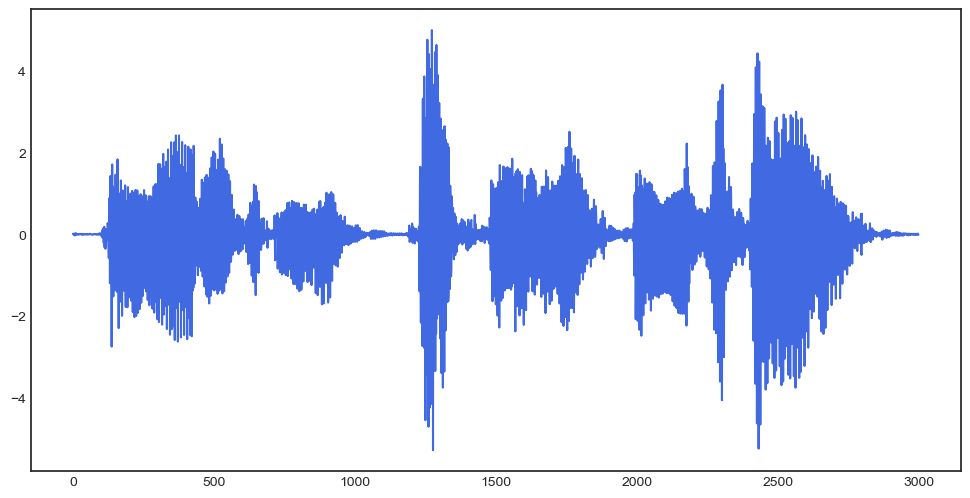

In [193]:
plt.plot(Xdf.iloc[idx[0],:], label=f'Emotion: {ydf[idx[0]]}', c = 'royalblue')

Text(0.5, 1.0, 'Decimated, emotion: angry')

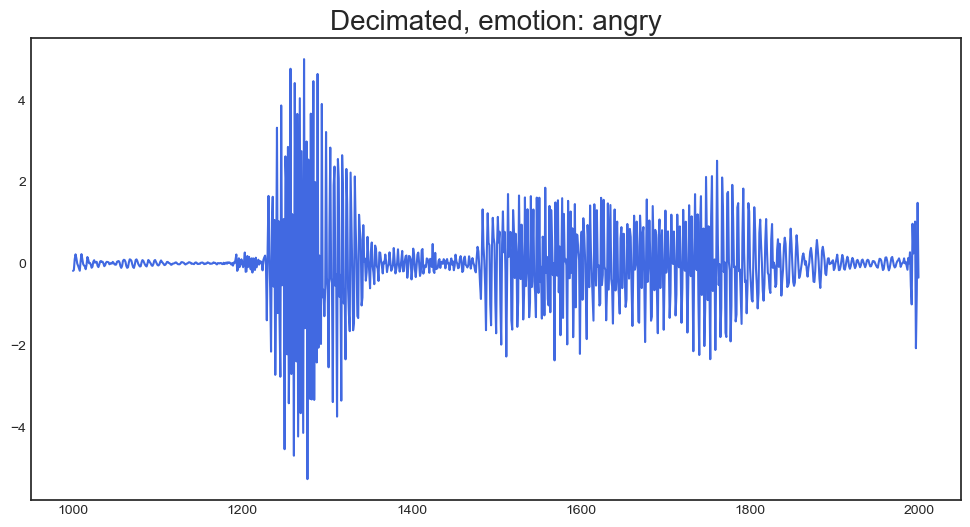

In [194]:
plt.plot(Xdf.iloc[idx[0],1000:2000], label=f'emotion: {ydf[idx[0]]}', c = 'royalblue')
plt.title(f'Decimated, emotion: {ydf[idx[0]]}', fontsize = 20)

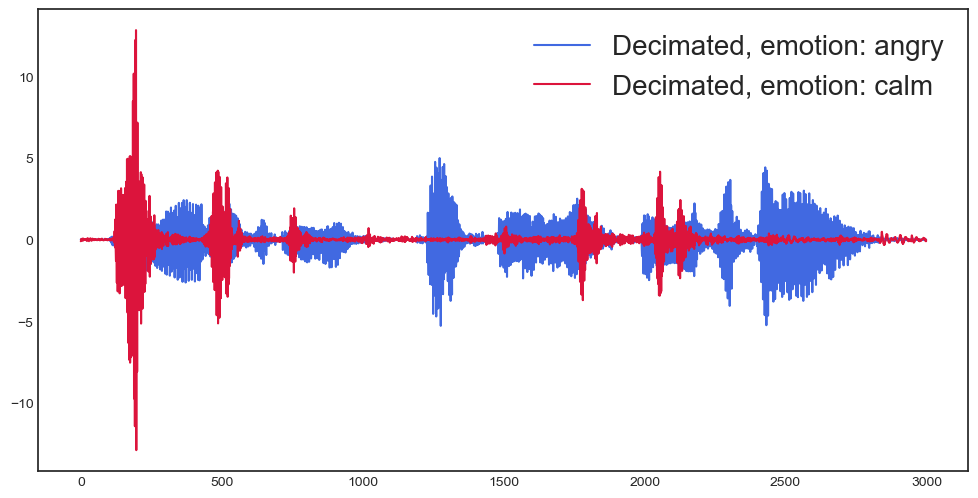

In [195]:
plt.plot(Xdf.iloc[idx[0],:], label=f'Decimated, emotion: {ydf[idx[0]]}', c = 'royalblue')
plt.plot(Xdf.iloc[idx[1],:], label=f'Decimated, emotion: {ydf[idx[1]]}', c = 'crimson')
plt.legend(fontsize = 20)

### Approximations

In [196]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

#### DFT

In [197]:
n_coefs = 150

dft = DiscreteFourierTransform(n_coefs=n_coefs)
ts_dft = dft.fit_transform(Xdf)

Xdf_dft = pd.DataFrame(dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(Xdf.columns)))
Xdf_dft.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.033247,-0.030068,-0.026938,-0.023879,-0.020911,-0.018053,-0.015323,-0.012737,-0.010309,-0.008051,-0.005974,-0.004086,-0.002392,-0.000895,0.000403,0.001504,0.002410,0.003129,0.003666,0.004032,0.004238,0.004296,0.004220,0.004025,0.003726,0.003339,0.002881,0.002369,0.001817,0.001242,0.000658,0.000078,-0.000483,-0.001015,-0.001509,-0.001955,-0.002347,-0.002680,-0.002950,-0.003157,-0.003298,-0.003376,-0.003394,-0.003356,-0.003266,-0.003131,-0.002957,-0.002753,-0.002525,-0.002282,-0.002032,-0.001781,-0.001539,-0.001310,-0.001102,-0.000919,-0.000766,-0.000646,-0.000561,-0.000513,-0.000501,-0.000524,-0.000581,-0.000668,-0.000782,-0.000919,-0.001073,-0.001240,-0.001413,-0.001588,-0.001758,-0.001918,-0.002064,-0.002189,-0.002291,-0.002365,-0.002410,-0.002424,-0.002405,-0.002355,-0.002273,-0.002161,-0.002023,-0.001860,-0.001678,-0.001481,-0.001273,-0.001059,-0.000845,-0.000636,-0.000437,-0.000252,-0.000087,0.000056,0.000172,0.000260,0.000318,0.000344,0.000339,0.000304,...,-0.038772,-0.036740,-0.034837,-0.033063,-0.031416,-0.029892,-0.028489,-0.027201,-0.026024,-0.024952,-0.023977,-0.023093,-0.022293,-0.021570,-0.020914,-0.020320,-0.019779,-0.019283,-0.018828,-0.018405,-0.018010,-0.017637,-0.017282,-0.016943,-0.016616,-0.016301,-0.015997,-0.015705,-0.015426,-0.015164,-0.014921,-0.014702,-0.014513,-0.014358,-0.014245,-0.014179,-0.014170,-0.014223,-0.014346,-0.014547,-0.014833,-0.015212,-0.015688,-0.016270,-0.016961,-0.017767,-0.018691,-0.019735,-0.020902,-0.022191,-0.023603,-0.025135,-0.026783,-0.028544,-0.030412,-0.032379,-0.034438,-0.036579,-0.038791,-0.041063,-0.043382,-0.045734,-0.048105,-0.050479,-0.052840,-0.055173,-0.057461,-0.059686,-0.061831,-0.063879,-0.065814,-0.067618,-0.069277,-0.070774,-0.072096,-0.073228,-0.074158,-0.074876,-0.075371,-0.075636,-0.075665,-0.075451,-0.074993,-0.074290,-0.073343,-0.072154,-0.070730,-0.069077,-0.067204,-0.065123,-0.062846,-0.060388,-0.057766,-0.054998,-0.052102,-0.049099,-0.046010,-0.042858,-0.039665,-0.036454
1,0.054587,0.056063,0.056942,0.057243,0.056994,0.056236,0.055014,0.053382,0.051401,0.049135,0.046652,0.044022,0.041315,0.038601,0.035947,0.033414,0.031063,0.028945,0.027105,0.025582,0.024406,0.023597,0.023169,0.023125,0.023460,0.024162,0.025209,0.026575,0.028224,0.030117,0.032210,0.034457,0.036808,0.039212,0.041620,0.043980,0.046248,0.048377,0.050327,0.052063,0.053554,0.054775,0.055707,0.056336,0.056656,0.056666,0.056371,0.055780,0.054910,0.053779,0.052411,0.050832,0.049069,0.047153,0.045113,0.042980,0.040782,0.038546,0.036299,0.034061,0.031852,0.029688,0.027581,0.025539,0.023566,0.021664,0.019828,0.018053,0.016331,0.014651,0.012999,0.011363,0.009727,0.008077,0.006401,0.004684,0.002917,0.001091,-0.000800,-0.002760,-0.004787,-0.006879,-0.009029,-0.011226,-0.013459,-0.015710,-0.017962,-0.020193,-0.022382,-0.024506,-0.026541,-0.028463,-0.030250,-0.031881,-0.033336,-0.034599,-0.035656,-0.036496,-0.037114,-0.037507,...,0.021772,0.025974,0.030150,0.034234,0.038158,0.041860,0.045278,0.048356,0.051045,0.053300,0.055087,0.056379,0.057159,0.057420,0.057162,0.056399,0.055152,0.053451,0.051335,0.048852,0.046055,0.043002,0.039756,0.036384,0.032953,0.029529,0.026180,0.022968,0.019950,0.017181,0.014706,0.012564,0.010785

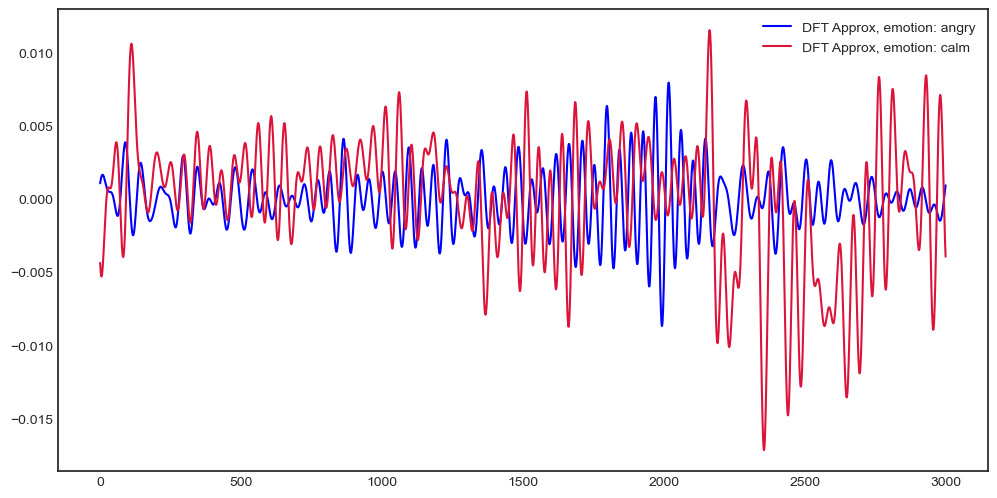

In [198]:
#plt.plot(Xdf.iloc[idx,:], label='Original', c = 'royalblue')
plt.plot(Xdf_dft.iloc[idx[0],:], label=f'DFT Approx, emotion: {ydf[idx[0]]}', c = 'blue')
plt.plot(Xdf_dft.iloc[idx[1],:], label=f'DFT Approx, emotion: {ydf[idx[1]]}', c = 'crimson')
plt.legend(fontsize = 20, loc = 'best')

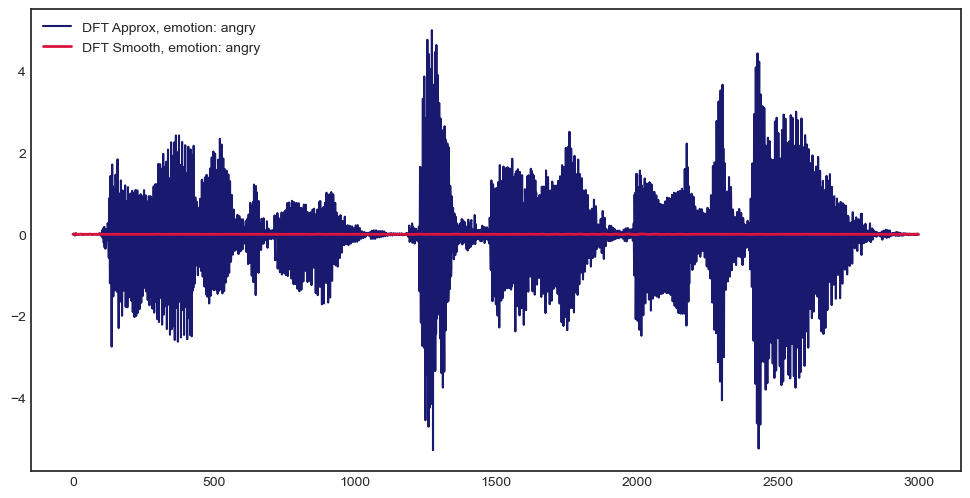

In [199]:
plt.plot(Xdf.iloc[idx[0],:], label=f'DFT Approx, emotion: {ydf[idx[0]]}', c = 'midnightblue')
plt.plot(Xdf_dft.values[idx[0],:], label=f'DFT Smooth, emotion: {ydf[idx[0]]}', c = 'crimson', linewidth = 2)
plt.legend(fontsize = 20, loc = 'best')

In [200]:
# distances only limited data points
cb_dist = cityblock(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
euc_dist = euclidean(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
dtw_dist = dtw(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:], global_constraint='itakura')

cb_dist_dft = cityblock(Xdf_dft.iloc[idx[0],:], Xdf_dft.iloc[idx[1],:])
euc_dist_dft = euclidean(Xdf_dft.iloc[idx[0],:], Xdf_dft.iloc[idx[1],:])
dtw_dist_dft = dtw(Xdf_dft.iloc[idx[0],:], Xdf_dft.iloc[idx[1],:], global_constraint='itakura')

print('No Approx')
print(f'Manhattan:\t{cb_dist}')
print(f'Euclidean:\t{euc_dist}')
print(f'DTW:\t{dtw_dist}')
print()
print('DFT')
print(f'Manhattan:\t{cb_dist_dft}')
print(f'Euclidean:\t{euc_dist_dft}')
print(f'DTW:\t{dtw_dist_dft}')

No Approx
Manhattan:	2457.3446069139345
Euclidean:	77.66299230655783
DTW:	58.38847018537529

DFT
Manhattan:	11.54297180103659
Euclidean:	0.272262724488372
DTW:	0.1377497228382045


### SVD

In [201]:
n_components = 5
svd = TruncatedSVD(n_components = n_components)
ts_svd = svd.fit_transform(Xdf).reshape(len(Xdf), n_components)

Xdf_svd = pd.DataFrame(svd.inverse_transform(ts_svd).reshape(len(Xdf), len(Xdf.columns)))
Xdf_svd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.002716,-0.000127,-0.003373,0.001125,0.003733,-0.001317,-0.007439,-0.004157,0.001684,-0.001682,-0.001425,-0.000561,0.000119,-0.001367,0.000585,0.005787,-0.001669,-0.005626,-0.001690,0.005857,-0.009298,-0.021626,0.008989,0.003395,-0.007290,0.019431,-0.013120,-0.025907,0.026732,-0.001089,-0.013154,0.018045,-0.034808,-0.009502,0.038531,0.006543,0.012583,0.018988,-0.025679,-0.040359,0.024998,-0.043380,-0.046341,0.069467,0.007875,-0.008300,-0.023526,-0.025798,0.026025,-0.033000,0.018197,0.056013,-0.003707,0.002678,-0.064286,-0.027054,0.060435,-0.012927,0.043549,0.059187,-0.065127,0.001316,0.043133,-0.029490,0.017724,0.038090,-0.034323,0.020766,0.026369,-0.082107,0.008205,0.066229,-0.019352,-0.009849,0.042148,0.029719,-0.032813,-0.015249,0.054774,0.047409,-0.025597,-0.029794,-0.000524,-0.042955,-0.003220,0.044437,-0.003543,0.034442,0.018700,-0.033679,0.020417,-0.040889,-0.039785,0.051543,0.012286,0.008344,0.017146,-0.021945,-0.029806,0.000186,...,-0.010458,0.042660,-0.032446,-0.006646,0.020008,-0.007635,0.005911,0.015292,-0.029974,-0.010133,0.043182,0.006009,-0.010629,-0.004366,-0.010651,0.005950,0.013947,0.001680,0.001272,-0.001456,-0.011424,0.009578,-0.007874,-0.022167,0.030968,0.011622,-0.011333,0.007434,-0.012133,0.021405,0.012344,-0.012810,0.027066,-0.014876,-0.006810,0.036388,-0.006840,-0.005569,0.013669,-0.014880,-0.022764,0.008287,0.016141,0.014519,0.014338,-0.002585,0.007301,0.005685,-0.015522,0.001774,-0.007204,-0.009732,0.028435,0.007091,-0.004054,0.011301,-0.001112,0.005642,-0.001596,0.004995,0.017933,-0.001507,0.010881,-0.001499,-0.016348,0.007726,-0.003142,-0.001547,0.010290,0.000226,-0.001620,0.003919,0.008154,0.000603,0.011370,0.007551,-0.010835,0.003325,0.004962,0.001326,0.006942,0.000462,-0.002044,0.010430,0.001411,-0.008477,0.003641,-0.004595,0.003517,0.002793,-0.014483,0.000657,0.007397,0.011056,0.003789,-0.001064,0.003087,-0.001668,0.009324,-0.001906
1,0.001159,-0.000914,0.000941,-0.001583,-0.001075,0.001704,-0.002398,-0.001267,0.001971,-0.001392,-0.000634,0.000530,-0.000494,-0.000120,-0.000295,0.001604,0.001534,-0.000601,-0.000993,0.000358,-0.002402,-0.001005,0.003506,-0.005658,-0.002273,0.004711,-0.001061,-0.000207,-0.004458,0.000511,0.005085,-0.002498,-0.004119,-0.001871,0.002823,0.001483,0.007650,-0.006966,-0.009356,0.016621,-0.002838,-0.005445,0.011601,-0.000360,-0.008288,-0.013254,-0.003279,0.010102,0.000070,0.007659,0.015704,-0.001401,0.001291,-0.005704,-0.001608,0.010951,-0.013187,-0.009347,-0.005275,0.011503,0.009003,-0.011770,0.006861,-0.014889,-0.000205,0.022647,-0.011478,-0.011370,0.002318,0.005818,0.008006,0.003780,-0.018636,-0.009049,0.013297,-0.007692,0.000645,0.016490,0.004253,0.002088,-0.014628,-0.017040,0.008724,-0.008576,0.002935,0.018413,-0.009223,0.005165,0.013302,-0.013752,-0.013558,0.010655,-0.002785,0.006968,0.014051,-0.028132,-0.002339,0.021415,-0.010718,-0.001676,...,0.010631,-0.003565,-0.016656,0.003104,-0.002086,-0.000356,0.011303,-0.001900,-0.008548,-0.001481,-0.002943,0.000555,-0.004713,-0.007573,0.005512,-0.002425,-0.004806,0.003690,0.001790,-0.006070,-0.005919,0.006195,-0.002916,-0.006019,0.006349,-0.005004,-0.010977,0.007903,0.004825,-0.006901,0.003679,-0.000780,-0.004110,0.003019,-0.004337,-0.001

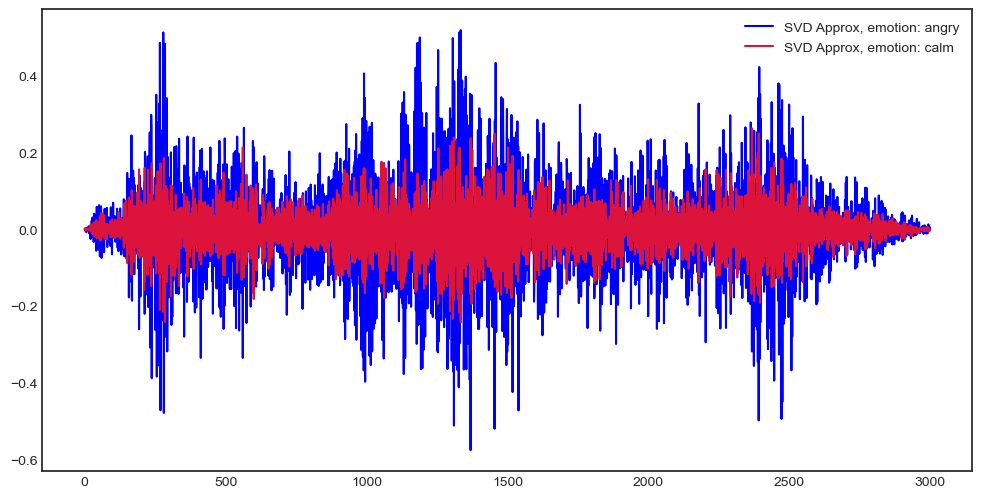

In [202]:
#plt.plot(Xdf.iloc[idx,:], label='Original', c = 'royalblue')
plt.plot(Xdf_svd.iloc[idx[0],:], label=f'SVD Approx, emotion: {ydf[idx[0]]}', c = 'blue')
plt.plot(Xdf_svd.iloc[idx[1],:], label=f'SVD Approx, emotion: {ydf[idx[1]]}', c = 'crimson')
plt.legend()

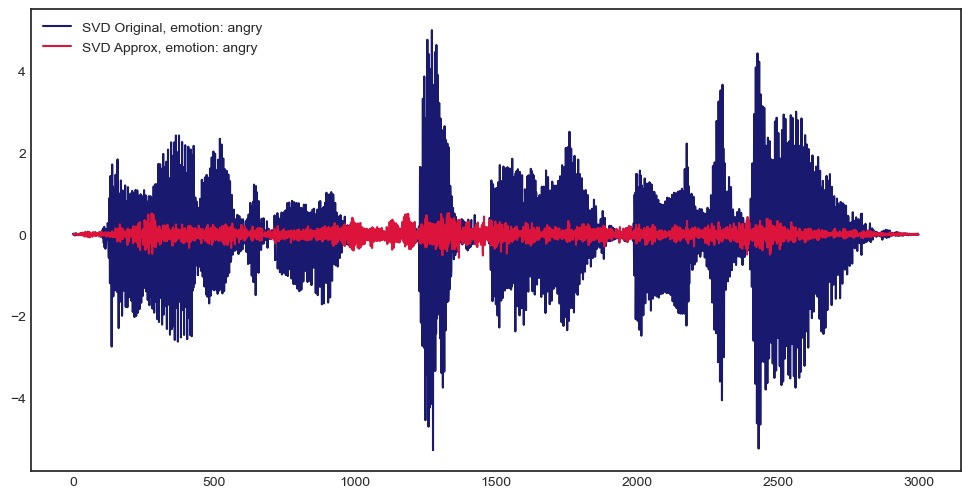

In [203]:
plt.plot(Xdf.iloc[idx[0],:], label=f'SVD Original, emotion: {ydf[idx[0]]}', c = 'midnightblue')
plt.plot(Xdf_svd.iloc[idx[0],:], label=f'SVD Approx, emotion: {ydf[idx[0]]}', c = 'crimson')
plt.legend()

In [204]:
# distances only limited data points
cb_dist = cityblock(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
euc_dist = euclidean(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
dtw_dist = dtw(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:], global_constraint='itakura')

cb_dist_svd = cityblock(Xdf_svd.iloc[idx[0],:], Xdf_svd.iloc[idx[1],:])
euc_dist_svd = euclidean(Xdf_svd.iloc[idx[0],:], Xdf_svd.iloc[idx[1],:])
dtw_dist_svd = dtw(Xdf_svd.iloc[idx[0],:], Xdf_svd.iloc[idx[1],:], global_constraint='itakura')

print('No Approx')
print(f'Manhattan:\t{cb_dist}')
print(f'Euclidean:\t{euc_dist}')
print(f'DTW:\t{dtw_dist}')
print()
print('SVD')
print(f'Manhattan:\t{cb_dist_svd}')
print(f'Euclidean:\t{euc_dist_svd}')
print(f'DTW:\t{dtw_dist_svd}')

No Approx
Manhattan:	2457.3446069139345
Euclidean:	77.66299230655783
DTW:	58.38847018537529

SVD
Manhattan:	404.37169361581107
Euclidean:	10.120692147477643
DTW:	4.844129019629461


### PAA

In [205]:
n_segments = 150

paa = PiecewiseAggregateApproximation(n_segments = n_segments)
ts_paa = paa.fit_transform(Xdf).reshape(len(Xdf), n_segments)

Xdf_paa = pd.DataFrame(paa.inverse_transform(ts_paa).reshape(len(Xdf), len(Xdf.columns)))
Xdf_paa.head()

c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001021,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001599,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001726,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.001585,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,-0.000993,...,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.021264,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.020332,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.024525,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.061127,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697,-0.068697
1,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.038126,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.041825,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.045815,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,0.030740,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,-0.044876,...,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021299,0.021838,0.021838,0.021838,0.021838,0.021838,0.021838,0.021838,0.021838,0.021838,0.021838,0.0

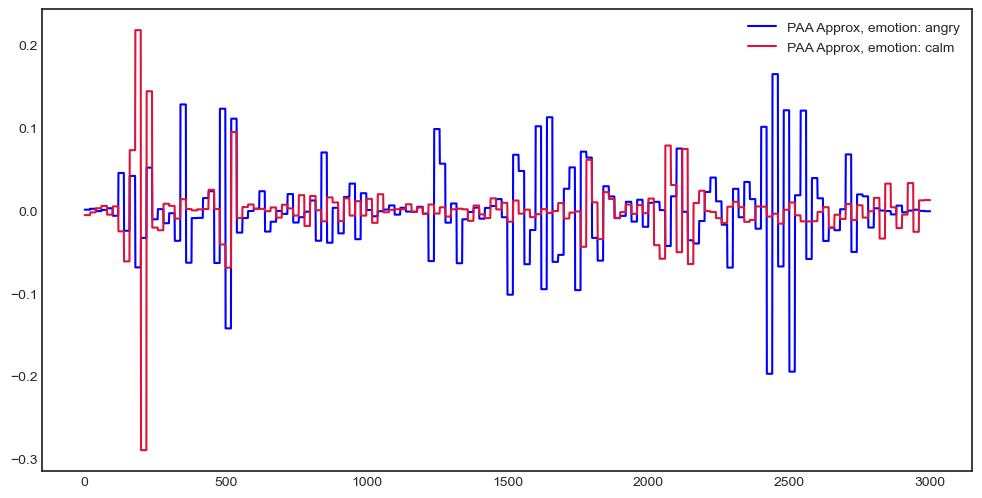

In [206]:
#plt.plot(Xdf.iloc[idx,:], label='Original', c = 'royalblue')
plt.plot(Xdf_paa.iloc[idx[0],:], label=f'PAA Approx, emotion: {ydf[idx[0]]}', c = 'blue')
plt.plot(Xdf_paa.iloc[idx[1],:], label=f'PAA Approx, emotion: {ydf[idx[1]]}', c = 'crimson')
plt.legend(fontsize = 20, loc = 'best')

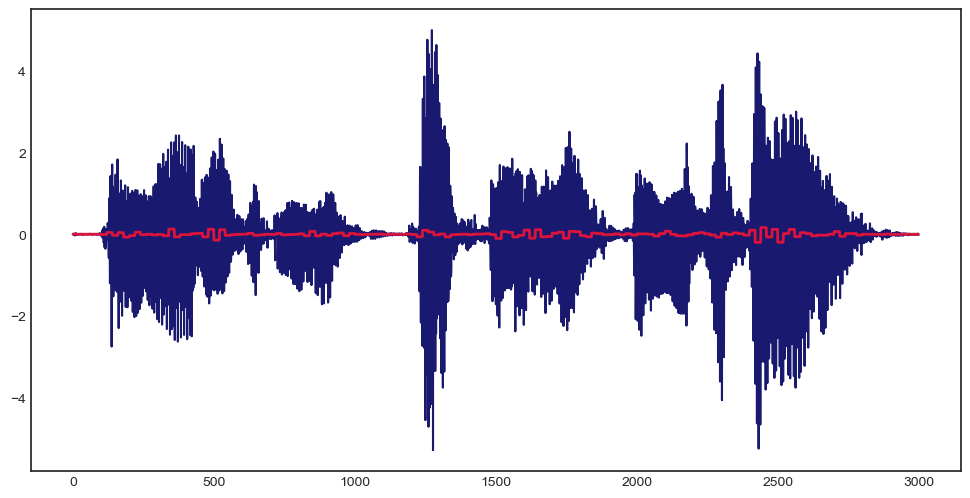

In [207]:
plt.plot(Xdf.iloc[idx[0],:], label=f'PAA Original, emotion: {ydf[idx[0]]}', c = 'midnightblue')
plt.plot(Xdf_paa.iloc[idx[0],:], label=f'PAA Approx, emotion: {ydf[idx[0]]}', c = 'crimson', linewidth = 2)

In [208]:
# distances only limited data points
cb_dist = cityblock(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
euc_dist = euclidean(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
dtw_dist = dtw(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:], global_constraint='itakura')

cb_dist_paa = cityblock(Xdf_paa.iloc[idx[0],:], Xdf_paa.iloc[idx[1],:])
euc_dist_paa = euclidean(Xdf_paa.iloc[idx[0],:], Xdf_paa.iloc[idx[1],:])
dtw_dist_paa = dtw(Xdf_paa.iloc[idx[0],:], Xdf_paa.iloc[idx[1],:], global_constraint='itakura')

print('No Approx')
print(f'Manhattan:\t{cb_dist}')
print(f'Euclidean:\t{euc_dist}')
print(f'DTW:\t{dtw_dist}')
print()
print('PAA')
print(f'Manhattan:\t{cb_dist_paa}')
print(f'Euclidean:\t{euc_dist_paa}')
print(f'DTW:\t{dtw_dist_paa}')

No Approx
Manhattan:	2457.3446069139345
Euclidean:	77.66299230655783
DTW:	58.38847018537529

PAA
Manhattan:	118.46931599451032
Euclidean:	3.4082633321213978
DTW:	2.6195363169370394


### SAX 

In [230]:
n_paa = 150
alphabet_size_avg = 100

sax = SymbolicAggregateApproximation(n_segments = n_paa, alphabet_size_avg = alphabet_size_avg)
ts_sax = sax.fit_transform(Xdf).reshape(len(Xdf), n_paa)

Xdf_sax = pd.DataFrame(sax.inverse_transform(ts_sax).reshape(len(Xdf), len(Xdf.columns)))
Xdf_sax.head()

c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\User\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,...,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.012533,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707,-0.062707
1,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,-0.037608,...,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.012533,0.0

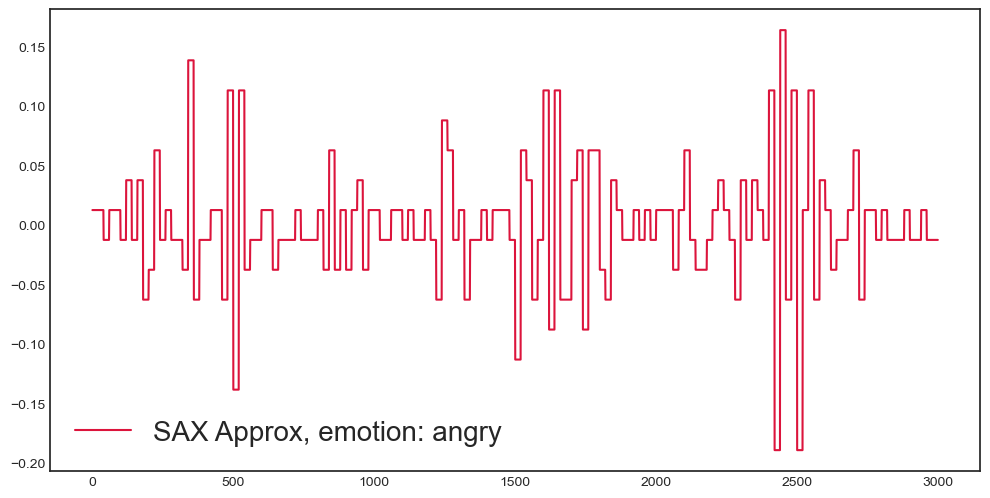

In [231]:
#plt.plot(Xdf.iloc[idx,:], label='Original', c = 'royalblue')
plt.plot(Xdf_sax.iloc[idx[0],:], label=f'SAX Approx, emotion: {ydf[idx[0]]}', c = 'crimson')
plt.legend(fontsize = 20, loc = 'best')

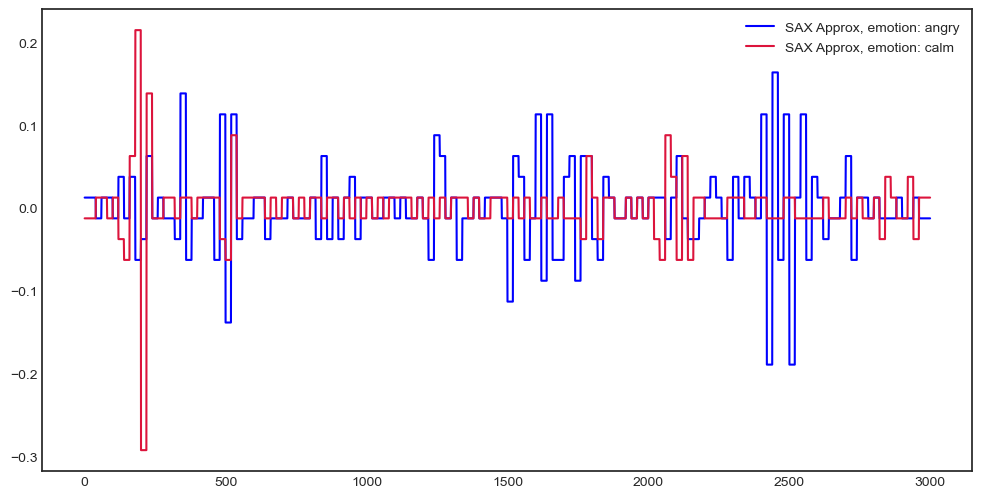

In [232]:
#plt.plot(Xdf.iloc[idx,:], label='Original', c = 'royalblue')
plt.plot(Xdf_sax.iloc[idx[0],:], label=f'SAX Approx, emotion: {ydf[idx[0]]}', c = 'blue')
plt.plot(Xdf_sax.iloc[idx[1],:], label=f'SAX Approx, emotion: {ydf[idx[1]]}', c = 'crimson')
plt.legend()

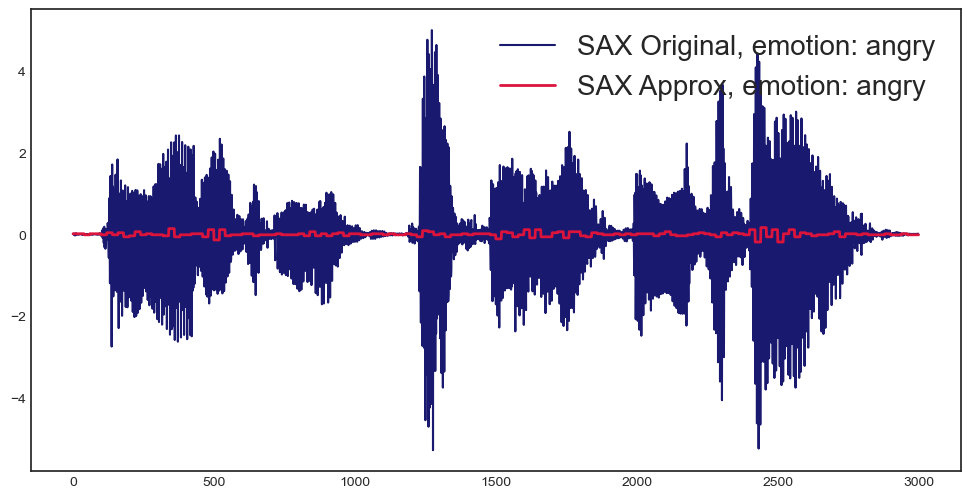

In [233]:
plt.plot(Xdf.iloc[idx[0],:], label=f'SAX Original, emotion: {ydf[idx[0]]}', c = 'midnightblue')
plt.plot(Xdf_sax.iloc[idx[0],:], label=f'SAX Approx, emotion: {ydf[idx[0]]}', c = 'crimson', linewidth = 2)
plt.legend(fontsize = 20, loc = 'best')

In [234]:
# distances only limited data points
cb_dist = cityblock(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
euc_dist = euclidean(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:])
dtw_dist = dtw(Xdf.iloc[idx[0],:], Xdf.iloc[idx[1],:], global_constraint='itakura')

cb_dist_sax = cityblock(Xdf_sax.iloc[idx[0],:], Xdf_sax.iloc[idx[1],:])
euc_dist_sax = euclidean(Xdf_sax.iloc[idx[0],:], Xdf_sax.iloc[idx[1],:])
dtw_dist_sax = dtw(Xdf_sax.iloc[idx[0],:], Xdf_sax.iloc[idx[1],:], global_constraint='itakura')

print('No Approx')
print(f'Manhattan:\t{cb_dist}')
print(f'Euclidean:\t{euc_dist}')
print(f'DTW:\t{dtw_dist}')
print()
print('SAX')
print(f'Manhattan:\t{cb_dist_sax}')
print(f'Euclidean:\t{euc_dist_sax}')
print(f'DTW:\t{dtw_dist_sax}')

No Approx
Manhattan:	2457.3446069139345
Euclidean:	77.66299230655783
DTW:	58.38847018537529

SAX
Manhattan:	122.5941713316395
Euclidean:	3.4586892196551697
DTW:	2.6056683855065685


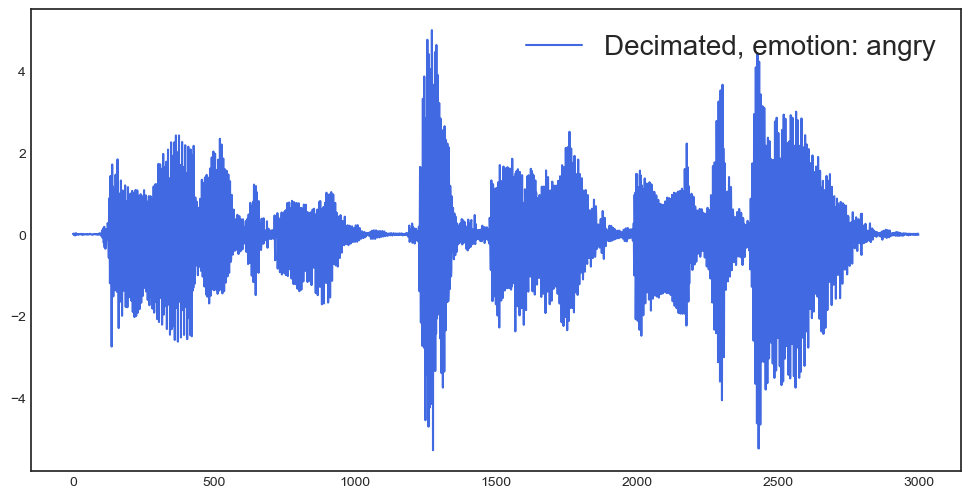

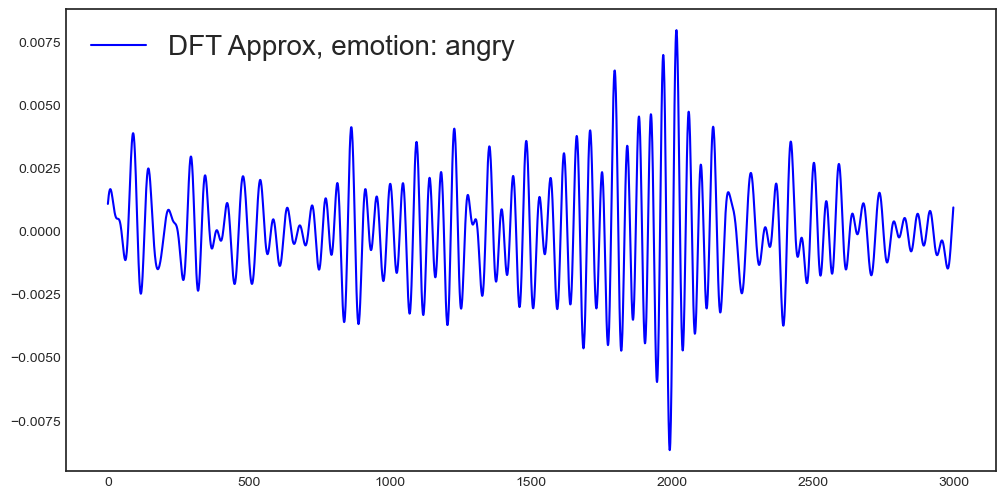

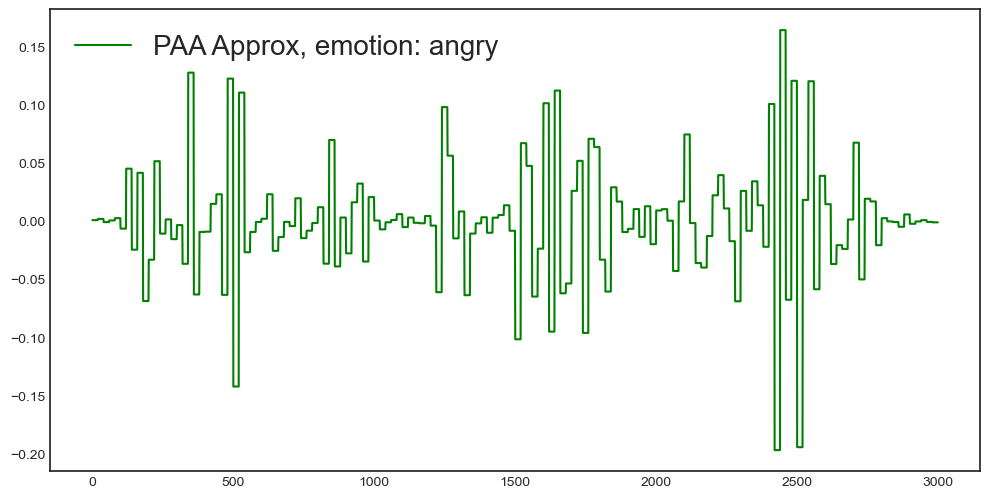

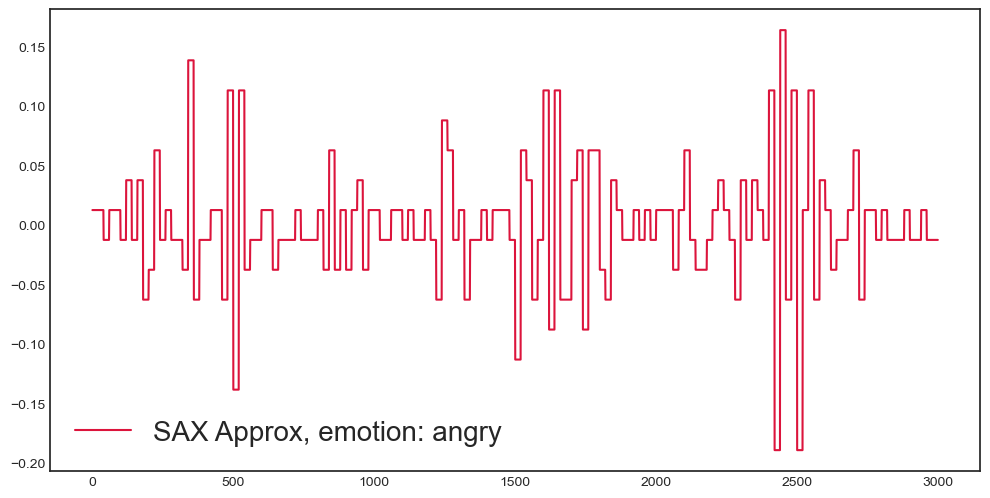

In [235]:
plt.plot(Xdf.values[idx[0],:], label=f'Decimated, emotion: {ydf[idx[0]]}', c = 'royalblue')
plt.legend(fontsize = 20, loc = 'best')
plt.show()
plt.plot(Xdf_dft.iloc[idx[0],:], label=f'DFT Approx, emotion: {ydf[idx[0]]}', c = 'blue')
plt.legend(fontsize = 20, loc = 'best')
plt.show()
plt.plot(Xdf_paa.iloc[idx[0],:], label=f'PAA Approx, emotion: {ydf[idx[0]]}', c = 'green')
plt.legend(fontsize = 20, loc = 'best')
plt.show()
plt.plot(Xdf_sax.iloc[idx[0],:], label=f'SAX Approx, emotion: {ydf[idx[0]]}', c = 'crimson')
plt.legend(fontsize = 20, loc = 'best')
plt.show()

## Exporting different datasets to work on

In [236]:
# first we concatenate the Xdfs with ydfs
df = pd.concat([ydf,Xdf],axis=1) # only decimated

df_dft = pd.concat([ydf, Xdf_dft],axis=1)
df_svd = pd.concat([ydf, Xdf_svd],axis=1)
df_paa = pd.concat([ydf, Xdf_paa],axis=1)
df_sax = pd.concat([ydf, Xdf_sax],axis=1)

In [237]:
df.head() #ok

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,fearful,-0.024939,0.011531,0.003824,-0.001133,0.005707,-0.001231,0.004508,0.002861,-0.006809,-0.002455,-0.008473,-0.003656,-0.004014,-0.004081,0.005950,-0.006266,0.002655,0.005199,-0.002388,0.002790,-0.004896,-0.003888,-0.011808,-0.005966,0.002689,-0.005995,0.002272,-0.000651,0.003248,0.003091,0.000855,0.005420,-0.010229,-0.002090,-0.000407,-0.004342,0.004452,-0.001423,0.001522,-0.003836,0.000123,0.008093,-0.002499,0.003057,0.004796,0.001043,0.002957,-0.001237,-0.009326,-0.012498,-0.003765,0.004731,0.007440,0.000828,-0.008969,-0.013394,-0.014266,-0.006761,0.000831,0.004299,0.007456,0.009240,0.004579,-0.002338,-0.001615,-0.007719,-0.014684,-0.003640,-0.006833,-0.017676,-0.002104,0.006712,0.006691,0.012588,0.013060,0.009602,-0.001379,-0.009699,-0.012926,-0.021023,-0.019034,0.001825,-0.003813,-0.010256,0.014278,0.002935,0.008834,0.016889,-0.003138,0.016223,0.000259,-0.007359,0.003881,-0.016362,-0.008192,-0.013999,-0.010032,-0.001133,-0.002270,...,-0.047955,-0.039695,-0.028971,-0.028191,-0.032486,-0.046011,-0.046337,-0.000185,0.006110,-0.035009,-0.036698,-0.012348,0.015357,-0.003099,-0.037461,0.004957,0.005027,-0.030328,-0.005685,-0.026276,-0.032351,-0.007408,-0.023480,-0.025035,-0.036783,-0.034755,-0.027111,-0.039315,-0.027187,-0.027250,-0.025517,-0.021439,-0.030291,-0.024800,-0.020865,-0.027422,-0.025507,0.009184,0.025020,0.015680,0.030019,0.034245,0.024569,-0.005705,-0.031073,-0.024897,-0.029776,-0.022967,-0.026595,-0.048733,-0.037272,-0.035064,-0.046556,-0.035065,-0.025982,-0.036370,-0.041735,-0.036079,-0.043492,-0.051976,-0.051360,-0.049550,-0.048874,-0.055373,-0.050123,-0.049232,-0.068090,-0.060916,-0.048563,-0.061750,-0.063308,-0.056611,-0.064250,-0.071982,-0.068508,-0.066347,-0.069568,-0.069371,-0.072839,-0.075920,-0.065590,-0.055515,-0.056873,-0.066228,-0.078048,-0.075119,-0.062988,-0.070806,-0.078749,-0.066071,-0.068274,-0.079312,-0.065353,-0.061078,-0.079842,-0.074183,-0.063330,-0.075893,-0.069719,-0.060970
1,disgust,0.064653,0.190734,0.011558,-0.162009,-0.037188,0.224411,0.352410,0.234780,0.036427,-0.071036,-0.011462,0.073917,0.081487,0.011715,-0.234079,-0.228971,0.183224,0.317401,-0.035244,-0.240201,-0.010246,0.172881,0.218704,0.197638,0.018209,-0.011013,0.021879,-0.035680,-0.078389,-0.210429,-0.128129,0.142217,0.123096,-0.040811,-0.044870,0.112321,0.211681,0.090752,-0.002739,0.089437,0.153628,0.086231,-0.032899,-0.027769,0.080056,0.107240,0.095485,0.093573,0.102794,0.047095,0.009818,0.074596,0.037546,0.035131,0.043812,-0.007694,0.087373,0.037323,-0.110030,0.002981,0.132882,0.042545,-0.077000,-0.009067,0.069053,0.042197,-0.018646,-0.035681,0.059404,0.067314,0.012778,0.004086,0.012102,0.058697,0.053343,0.034074,0.028967,0.045676,0.060012,0.032055,-0.002826,-0.087177,-0.058526,-0.026556,-0.106130,-0.068623,-0.021751,-0.006735,-0.053514,-0.073075,0.073286,0.056309,-0.000303,0.033495,-0.063891,-0.061149,-0.022418,-0.109053,-0.142463,...,0.460495,0.160417,0.413590,0.692314,0.654476,0.257606,-0.124812,-0.280664,-0.113061,-0.198704,-0.614740,-0.704570,-0.803661,-0.066945,0.596232,-0.091878,-0.421540,0.060709,0.367456,0.183254,0.120372,0.337274,0.493234,0.340958,0.146922,0.289200,0.320827,0.183863,-0.070292,-0.309082,-0.220904,-0.095166,-0

In [238]:
#exporting df (if timestamps are changed, change also tstamps_in_k (in thousands))

#df.to_csv(f'data_p_dec_scld.csv', index=False)
##
#df_dft.to_csv(f'data_400_dft.csv', index=False)
#df_paa.to_csv(f'data_400_paa.csv', index=False)
#df_sax.to_csv(f'data_200_sax.csv', index=False)

In [239]:
#np.save('ts_400_dft.npy', ts_dft)
#np.save('ts_400_paa.npy', ts_paa)
#np.save('ts_200_sax.npy', ts_sax)